In [2]:
import pandas as pd 
import numpy as np 
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import regex as re

First let's load our raw data: tweets by Donald Trump.

In [18]:
data = pd.read_csv("../data/tweets_01-08-2021.csv")
print(data.shape)

(56571, 9)


We have ~56000 rows and 9 features. Let's take a look at some rows in our dataframe

In [4]:
data.head(10)

,id,text,isRetweet,isDeleted,device,favorites,retweets,date,isFlagged
0,98454970654916608,Republicans and Democrats have both created ou...,f,f,TweetDeck,49,255,2011-08-02 18:07:48,f
1,1234653427789070336,I was thrilled to be back in the Great city of...,f,f,Twitter for iPhone,73748,17404,2020-03-03 01:34:50,f
2,1218010753434820614,RT @CBS_Herridge: READ: Letter to surveillance...,t,f,Twitter for iPhone,0,7396,2020-01-17 03:22:47,f
3,1304875170860015617,The Unsolicited Mail In Ballot Scam is a major...,f,f,Twitter for iPhone,80527,23502,2020-09-12 20:10:58,f
4,1218159531554897920,RT @MZHemingway: Very friendly telling of even...,t,f,Twitter for iPhone,0,9081,2020-01-17 13:13:59,f
5,1217962723234983937,RT @WhiteHouse: President @realDonaldTrump ann...,t,f,Twitter for iPhone,0,25048,2020-01-17 00:11:56,f
6,1223640662689689602,Getting a little exercise this morning! https:...,f,f,Twitter for iPhone,285863,30209,2020-02-01 16:14:02,f
7,1319501865625784320,https://t.co/4qwCKQOiOw,f,f,Twitter for iPhone,130822,19127,2020-10-23 04:52:14,f
8,1319500520126664705,https://t.co/VlEu8yyovv,f,f,Twitter for iPhone,153446,20275,2020-10-23 04:46:53,f
9,1319500501269041154,https://t.co/z5CRqHO8vg,f,f,Twitter for iPhone,102150,14815,2020-10-23 04:46:49,f


Interesting, we have quite a lot of information on his tweets. We know the date, device, how many favorites and retweets it received, whether it was a retweet itself, and whether it was deleted, which is our outcome feature in this project. For the text itself, we can see that some tweets have the plain text itself, while others have "RT" text and links cluttering the text. We'll have to handle that as we analyze the text closely.

First, let's graph the frequency of tweets over time, to get an idea of our spread over time.

In [5]:
data['date']=pd.to_datetime(data['date'])
date_group = data
date_group.index = pd.to_datetime(data['date'])
date_group = data.groupby(pd.Grouper(freq='M')).count()
date_group = date_group["id"]
#date_group.head()
date_group.index[-1]

Timestamp('2021-01-31 00:00:00', freq='M')

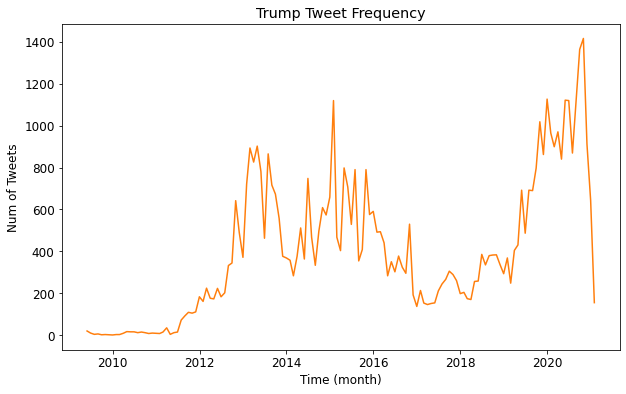

In [6]:
plt.rc('font', size=12)
fig, ax = plt.subplots(figsize=(10, 6))

# Specify how our lines should look
ax.plot(date_group.index, date_group, color='tab:orange')

# Same as above
ax.set_xlabel('Time (month)')
ax.set_ylabel('Num of Tweets')
ax.set_title('Trump Tweet Frequency')
plt.savefig("../figs/tweet_frequency.jpg")

There are some expected and unexpected results from this graph. Expectedly, we see that Trump's tweet frequency follows US election cycles, picking up 2015-2016 and 2019-2020. What is slightly unexpected is how sharply the decline in tweets was after each election, and how many more tweets there were in the 202 election cycle as opposed to the 2016 election cycle.

Now let's see some of the ratio balances in our data. How many tweets were retweets, or deleted? Or how many were from certain devices?

['TweetDeck' 'Twitter for iPhone' 'Twitter Media Studio'
 'Twitter for Android' 'Twitter Web Client' 'Twitter Web App' 'Instagram'
 'Twitter for iPad' 'Twitter Ads' 'Facebook' 'Periscope' 'TwitLonger Beta'
 'Twitter QandA' 'Twitlonger' 'Vine - Make a Scene'
 'Twitter for BlackBerry' 'Twitter for Websites' 'Twitter Mirror for iPad'
 'Neatly For BlackBerry 10' 'Media Studio']


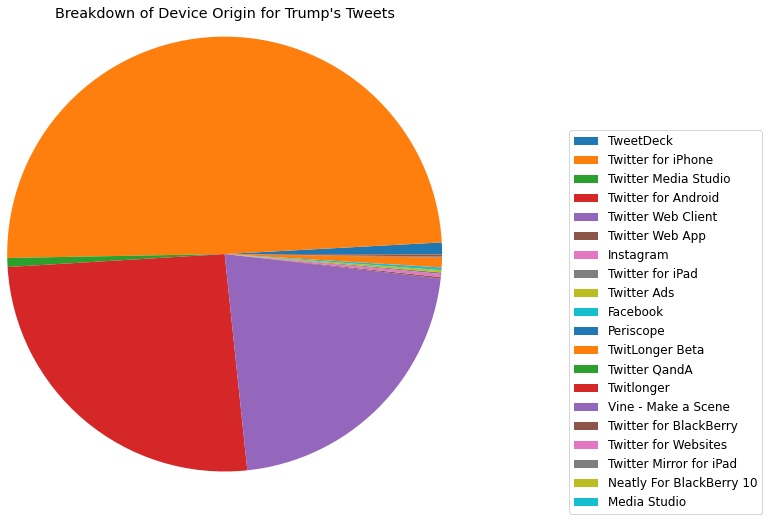

In [23]:
# Pie chart for devices
n = data.shape[0]
d = data.shape[1]

device_list = data['device'].unique()
device_ratios = []
for device in device_list:
    curr_ratio = data[data['device'] == device].shape[0]/n
    device_ratios.append(curr_ratio)

#myexplode = [0.2, 0, 0, 0]
print(device_list)
fig1, ax1 = plt.subplots(figsize=(6, 5))

ax1.pie(device_ratios, radius=2)
ax1.legend(
    loc='center right',
    labels = device_list,
    prop={'size': 12},
    bbox_to_anchor=(-0.5, 0, 3, 0.5),
)
ax1.set_title("Breakdown of Device Origin for Trump's Tweets", pad = 100)
plt.show() 
fig1.savefig("../figs/device_chart.jpg", bbox_inches = 'tight')

We can see that while the majority of tweets are from Trumps Offices' iPhone, Android, and desktop, there is a large variety of devices from which his tweets originate. This tells us that while the majority of the tweets likely came from his personal mobile devices over the years, there's a minority of tweets that likely came from an agent/communications director on his team.

ToDo: Add device breakdown overtime

[0.007760159799190398, 0.16683459723179722]
[0.011543016740025808, 0.8138622262289866]


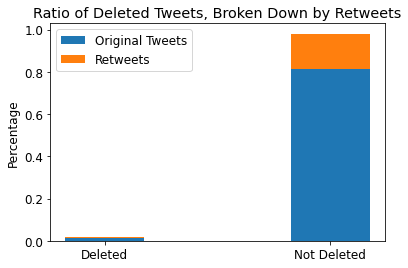

In [8]:
labels = ['Deleted', 'Not Deleted']
df_deleted = data[data['isDeleted'] == 't']
df_notdeleted = data[data['isDeleted'] == 'f']
dfs = [df_deleted, df_notdeleted]
normal_tweet_ratios = []
retweet_ratios = []

for df in dfs:
    normal_tweet_ratio = df[df['isRetweet'] == 'f'].shape[0]/n
    retweet_ratio = df[df['isRetweet'] == 't'].shape[0]/n
    normal_tweet_ratios.append(normal_tweet_ratio)
    retweet_ratios.append(retweet_ratio)

#men_means = [20, 35, 30, 35, 27]
#women_means = [25, 32, 34, 20, 25]
width = 0.35       # the width of the bars: can also be len(x) sequence
fig, ax = plt.subplots()
print(str(retweet_ratios) + "\n" + str(normal_tweet_ratios))

ax.bar(labels, normal_tweet_ratios, width, label='Original Tweets')
ax.bar(labels, retweet_ratios, width, bottom=normal_tweet_ratios, label='Retweets')

ax.set_ylabel('Percentage')
ax.set_title('Ratio of Deleted Tweets, Broken Down by Retweets')
ax.legend()

plt.show()
fig.savefig("../figs/deletion_ratio.jpg")

We can see that the vast majority of Trump's tweets were not deleted, so we have an unbalanced dataset on our hands. In addition, among the deleted tweets, the balance between original tweets and retweets is close, while the balance of original tweets to retweets is majority original among the non-deleted tweets.

Now, let's examine the content of the tweets.

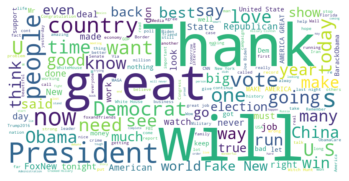

In [9]:
tweet_text =" ".join(tweet for tweet in data['text'])
tweet_text = re.sub(" &amp", ' ', tweet_text) # &amp
stopwords = set(STOPWORDS)
stopwords.update(["RT", "https", "http", "Donald", "Trump", "realDonaldTrump", "t", "co"])
wordcloud = WordCloud(stopwords=stopwords, background_color="white", width = 800, height = 400).generate(tweet_text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Now let's separate by tweets that were and weren't deleted.

In [10]:
undeleted_tweets = data[data['isDeleted'] == 'f']['text']
deleted_tweets = data[data['isDeleted'] == 't']['text']
print("Number of deleted tweets: " + str(deleted_tweets.shape[0]))
print("Number of not deleted tweets: " + str(undeleted_tweets.shape[0]))

Number of deleted tweets: 1092
Number of not deleted tweets: 55479


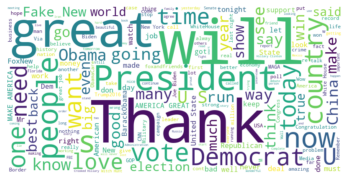

In [11]:
# Not deleted tweets
tweet_text =" ".join(tweet for tweet in undeleted_tweets)
tweet_text = re.sub(" &amp", ' ', tweet_text) # &amp
stopwords = set(STOPWORDS)
stopwords.update(["RT", "https", "http", "Donald", "Trump", "realDonaldTrump", "t", "co"])
wordcloud = WordCloud(stopwords=stopwords, background_color="white", width = 800, height = 400).generate(tweet_text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

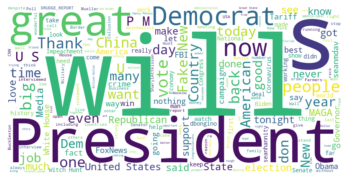

In [12]:
# Deleted tweets
tweet_text =" ".join(tweet for tweet in deleted_tweets)
tweet_text = re.sub(" &amp", ' ', tweet_text) # &amp
stopwords = set(STOPWORDS)
stopwords.update(["RT", "https", "http", "Donald", "Trump", "realDonaldTrump", "t", "co"])
wordcloud = WordCloud(stopwords=stopwords, background_color="white", width = 800, height = 400).generate(tweet_text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Can we look at the most popular tweets and see what they say?

In [13]:
df_favorite = data.sort_values(by = ['favorites'], ascending = False)
N = 5
top_N = df_favorite.iloc[0:N, 1]
for i in range(0,N):
    print(str(i + 1) + ". " + top_N.iloc[i])
    print()

1. Tonight, @FLOTUS and I tested positive for COVID-19. We will begin our quarantine and recovery process immediately. We will get through this TOGETHER!

2. Going welI, I think! Thank you to all. LOVE!!!

3. I WON THIS ELECTION, BY A LOT!

4. WE WILL WIN!

5. 71,000,000 Legal Votes. The most EVER for a sitting President!



Let's do the same process, but with a more cleaned dataset, with the sentiments only.

In [14]:
data = pd.read_csv("../output/cleaned_dataset.csv")
print(data.shape)

(54674, 3)


In [15]:
data.head()

,sentiment_text,VADER,TextBlob
0,republicans democrats created economic problems,-1,1.0
1,thrilled_back great city charlotte north_carol...,1,1.0
2,read letter surveillance court obtained cbs ne...,0,1.0
3,unsolicited mail_ballot scam major threat demo...,-1,1.0
4,friendly telling events comey apparent leaking...,1,1.0


Wordcloud of all tweet sentiments

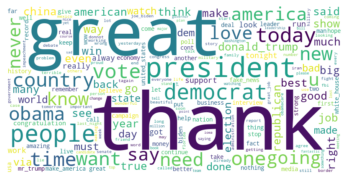

In [16]:
tweet_text =" ".join(tweet for tweet in data['sentiment_text'])
tweet_text = re.sub(" &amp", ' ', tweet_text) # &amp
stopwords = set(STOPWORDS)
stopwords.update(["RT", "https", "http", "Donald", "Trump", "realDonaldTrump", "t", "co"])
wordcloud = WordCloud(stopwords=stopwords, background_color="white", width = 800, height = 400).generate(tweet_text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()